In [ ]:
"""Medical chatbot -Intent Classificaion Model(Deep Learning version)
S·ª≠ d·ª•ng PhoBERT ƒë·ªÉ ph√¢n lo·∫°i √Ω ƒë·ªãnh
"""
!pip install transformers datasets accelerate torch


In [ ]:
import torch
if torch.cuda.is_available():
  print(f"ƒê√£ nh·∫≠n GPU{torch.cuda.get_device_name(0)}")
  device = torch.device("cuda")
else:
  print("Kh√¥ng nh·∫≠n ƒë∆∞·ª£c GPU")
  device = torch.device("cpu")
!nvidia-smi

ƒê√£ nh·∫≠n GPUTesla T4
Wed Oct 22 09:49:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DRIVE_PATH = '/content/drive/My Drive/Medical_Chatbot/'
DATA_CSV_PATH = os.path.join(DRIVE_PATH, 'Data','medical_intent_dataset_v4_balanced.csv')
MODEL_SAVE_PATH = os.path.join(DRIVE_PATH,'Model','intent_dl_phobert_v2')
#T·∫°o th∆∞ m·ª•c l∆∞u model ch∆∞a   c√≥
os.makedirs(MODEL_SAVE_PATH,exist_ok=True)


In [ ]:
import pandas as pd
from datasets import Dataset, Features, ClassLabel, Value
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# 1. T·∫£i Tokenizer cho PhoBERT
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

def load_training_data_from_csv(csv_path):
    """
    T·∫£i v√† chu·∫©n b·ªã d·ªØ li·ªáu t·ª´ file 5K CSV
    """
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
        print(f" ƒê√£ t·∫£i {len(df)} m·∫´u t·ª´ dataset 5K: {csv_path}")

        df = df.dropna(subset=['text', 'intent'])
        df['text'] = df['text'].astype(str)
        df['intent'] = df['intent'].astype(str)

        # T·∫°o b·∫£n ƒë·ªì nh√£n (label maps)
        labels_list = sorted(list(df['intent'].unique()))
        label2id = {label: i for i, label in enumerate(labels_list)}
        id2label = {i: label for i, label in enumerate(labels_list)}

        df['label'] = df['intent'].map(label2id)

        print(f"T√¨m th·∫•y {len(labels_list)} intents: {labels_list}")

        # Select only the necessary columns before creating the Dataset
        df_selected = df[['text', 'label']]

        features_schema = Features({
           'text': Value('string'),
           'label': ClassLabel(names=labels_list)
        })

        dataset = Dataset.from_pandas(df_selected, features=features_schema)
        return dataset, label2id, id2label
    except Exception as e:
        print(f" L·ªói nghi√™m tr·ªçng khi ƒë·ªçc file CSV: {e}")
        return None, None, None

def tokenize_function(examples):
    # Tokenize text v·ªõi padding v√† truncation
    return phobert_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# 2. T·∫£i d·ªØ li·ªáu
dataset, label2id, id2label = load_training_data_from_csv(DATA_CSV_PATH)

if dataset:
    # 3. Tokenize
    print("...ƒêang tokenize d·ªØ li·ªáu (c√≥ th·ªÉ m·∫•t v√†i ph√∫t)...")
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # 4. Chia train/test (v√≠ d·ª•: 85% train, 15% eval)
    train_test_split_dataset = tokenized_dataset.train_test_split(test_size=0.15, stratify_by_column='label')
    train_dataset = train_test_split_dataset['train']
    eval_dataset = train_test_split_dataset['test']

    print(f" K√≠ch th∆∞·ªõc: {len(train_dataset)} train, {len(eval_dataset)} evaluation")
else:
    print(" Kh√¥ng th·ªÉ ti·∫øp t·ª•c v√¨ kh√¥ng t·∫£i ƒë∆∞·ª£c d·ªØ li·ªáu.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

 ƒê√£ t·∫£i 1558 m·∫´u t·ª´ dataset 5K: /content/drive/My Drive/Medical_Chatbot/Data/medical_intent_dataset_v4_balanced.csv
T√¨m th·∫•y 11 intents: ['diet_lifestyle', 'dosage_question', 'drug_interaction', 'drug_question', 'emergency', 'general_health', 'greeting', 'medical_procedure', 'side_effects', 'symptom_inquiry', 'unknown']
...ƒêang tokenize d·ªØ li·ªáu (c√≥ th·ªÉ m·∫•t v√†i ph√∫t)...


Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

 K√≠ch th∆∞·ªõc: 1324 train, 234 evaluation


In [ ]:
#B∆∞·ªõc 4 :T·∫£i v√† c·∫•u h√¨nh m√¥ h√¨nh PhoBERT
#T·∫£i PhoBERT g·ªëc v√† thi·∫øt l·∫≠p c√°c th√¥ng s·ªë ƒë·ªÉ hu·∫•n luy·ªán

from transformers import (AutoModelForSequenceClassification, TrainingArguments,Trainer,EarlyStoppingCallback)
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
#T·∫£i m√¥ h√¨nh PhoBERT g·ªëc
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base-v2",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model.to(device)
#H√†m t√≠nh to√°n metrics
def compute_metrics(eval_pred):
  predictions,labels= eval_pred
  predictions = np.argmax(predictions,axis=1)
  accuracy = accuracy_score(labels,predictions)
  return {"accuracy":accuracy}
#C·∫•u h√¨nh training
training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH, #N∆°i l∆∞u check point
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",           # ƒê√°nh gi√° sau m·ªói epoch
    save_strategy="epoch",                 # L∆∞u model sau m·ªói epoch
    load_best_model_at_end=True,           # T·ª± ƒë·ªông t·∫£i model t·ªët nh·∫•t
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none" # Explicitly disable W&B logging
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Hu·∫•n luy·ªán (Fine tune) M√¥ h√¨nh
#1 Kh·ªüi t·∫°o Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  compute_metrics=compute_metrics,
  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  # Removed report_to="none" from here as it's in TrainingArguments
)
#2 B·∫•t ƒë·∫ßu hu·∫•n luy·ªán
print("B·∫Øt ƒê·∫ßu Hu·∫•n Luy·ªán")
trainer.train()

B·∫Øt ƒê·∫ßu Hu·∫•n Luy·ªán


TrainOutput(global_step=664, training_loss=0.6924489149487162, metrics={'train_runtime': 350.8469, 'train_samples_per_second': 37.737, 'train_steps_per_second': 2.366, 'total_flos': 696774374547456.0, 'train_loss': 0.6924489149487162, 'epoch': 8.0})

Plotting metrics...


<Figure size 1000x600 with 0 Axes>

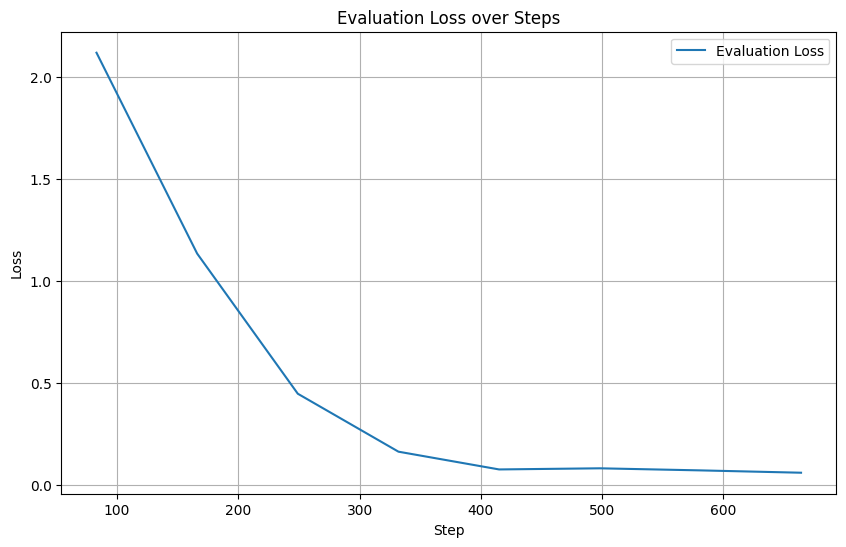

<Figure size 1000x600 with 0 Axes>

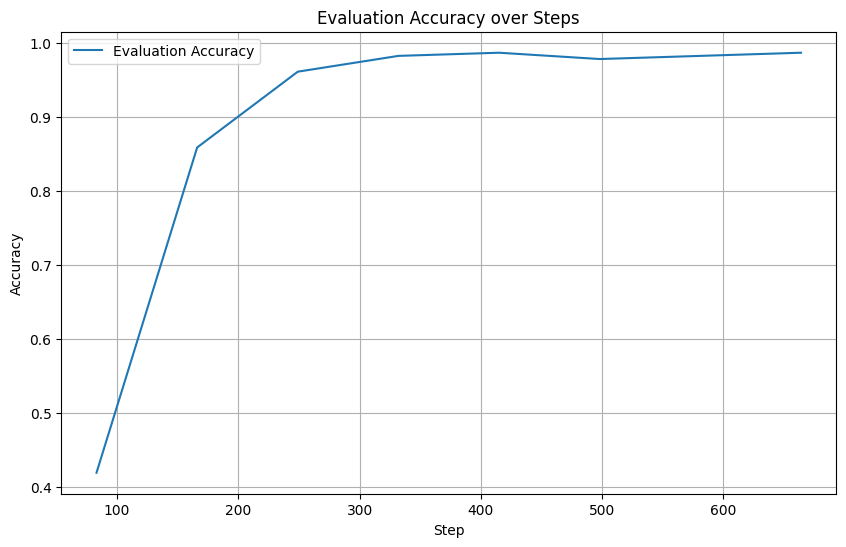

<Figure size 1000x600 with 0 Axes>

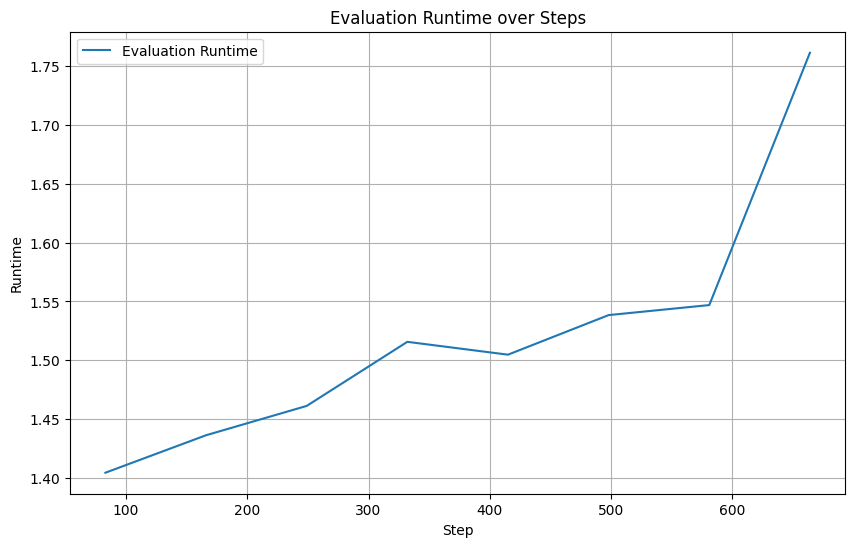

<Figure size 1000x600 with 0 Axes>

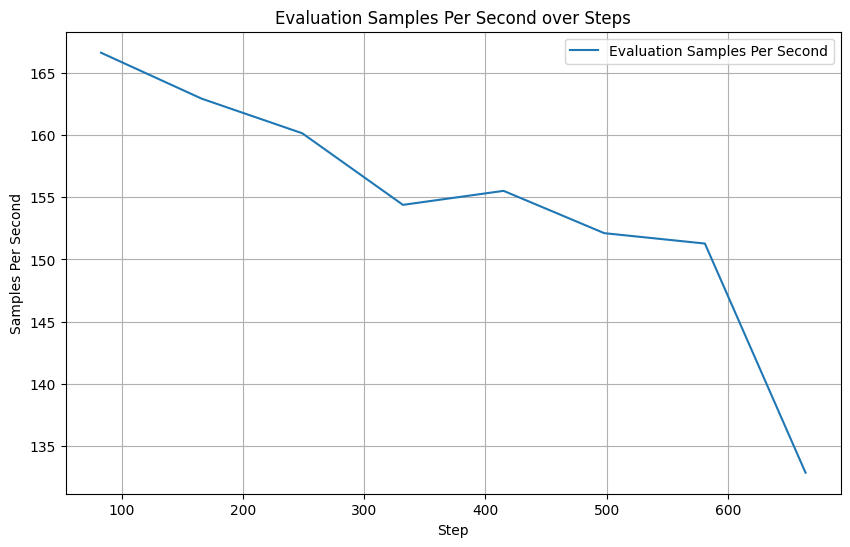

<Figure size 1000x600 with 0 Axes>

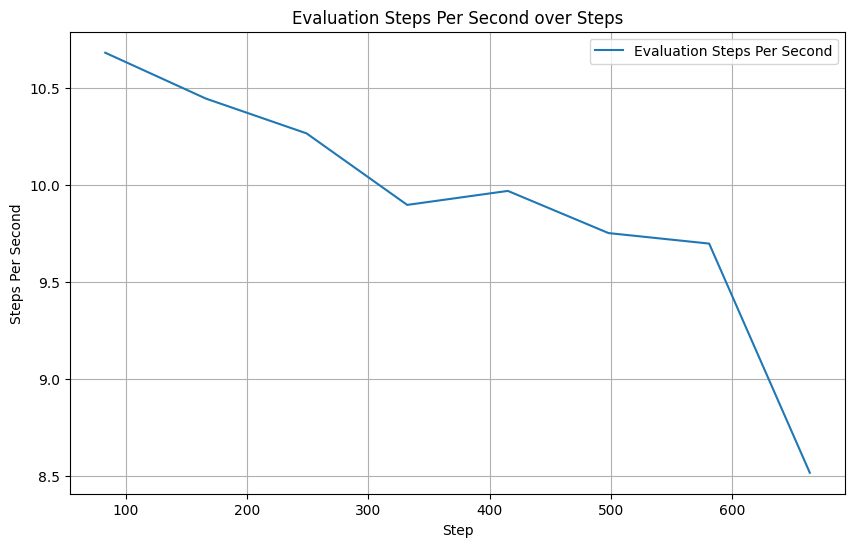

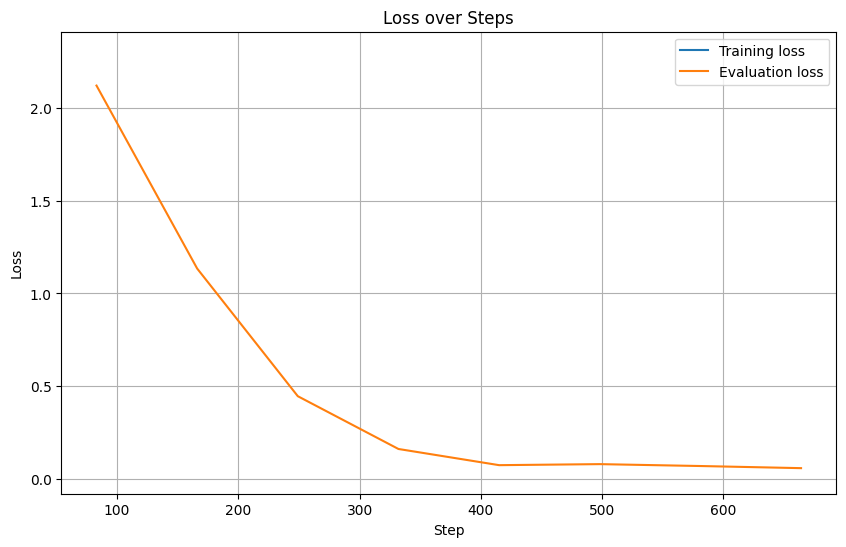

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

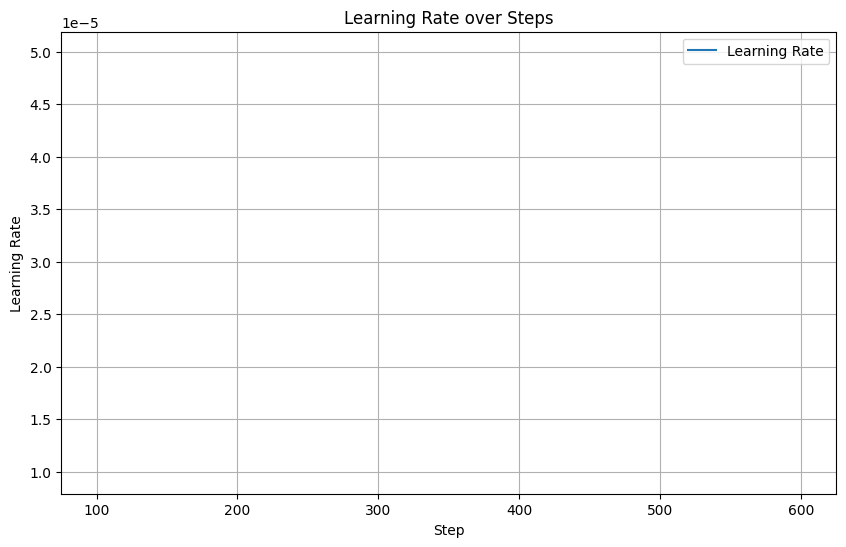

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd

def plot_training_metrics(log_history):
    """Plots training and evaluation metrics from the Trainer's log history."""

    # Convert log history to a pandas DataFrame
    logs_df = pd.DataFrame(log_history)

    # Filter out rows without step (these are typically evaluation logs)
    train_logs = logs_df.dropna(subset=['step']).set_index('step')
    eval_logs = logs_df[logs_df['eval_loss'].notna()].set_index('step')


    # Get all metric columns except step, epoch, and learning rate (which we might plot separately)
    metric_columns = [col for col in logs_df.columns if col not in ['step', 'epoch', 'learning_rate']]

    for metric in metric_columns:
        plt.figure(figsize=(10, 6))
        if f'eval_{metric}' in logs_df.columns:
             plt.plot(train_logs.index, train_logs[metric], label=f'Training {metric}')
             plt.plot(eval_logs.index, eval_logs[f'eval_{metric}'], label=f'Evaluation {metric}')
             plt.xlabel("Step")
             plt.ylabel(metric.replace('_', ' ').title())
             plt.title(f'{metric.replace("_", " ").title()} over Steps')
             plt.legend()
             plt.grid(True)
             plt.show()
        elif metric.startswith('eval_'):
             # Plot evaluation-only metrics
             plt.figure(figsize=(10, 6))
             plt.plot(eval_logs.index, eval_logs[metric], label=f'Evaluation {metric.replace("eval_", "").replace("_", " ").title()}')
             plt.xlabel("Step")
             plt.ylabel(metric.replace("eval_", "").replace('_', ' ').title())
             plt.title(f'Evaluation {metric.replace("eval_", "").replace("_", " ").title()} over Steps')
             plt.legend()
             plt.grid(True)
             plt.show()


    # Plot Learning Rate separately
    if 'learning_rate' in train_logs.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(train_logs.index, train_logs['learning_rate'], label='Learning Rate')
        plt.xlabel("Step")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate over Steps")
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming trainer is already defined and train() has been called
if 'trainer' in locals() and hasattr(trainer, 'state') and hasattr(trainer.state, 'log_history'):
    print("Plotting metrics...")
    plot_training_metrics(trainer.state.log_history)
else:
    print("Trainer or log history not found. Please train the model first.")

In [ ]:
import pandas as pd

if 'trainer' in locals() and hasattr(trainer, 'state') and hasattr(trainer.state, 'log_history'):
    logs_df = pd.DataFrame(trainer.state.log_history)

    # Filter for evaluation steps
    eval_logs = logs_df[logs_df['eval_loss'].notna()]

    if not eval_logs.empty:
        # Get the last evaluation result (which corresponds to the best model if load_best_model_at_end=True)
        final_eval_metrics = eval_logs.iloc[-1]

        print("Final Evaluation Metrics:")
        for metric, value in final_eval_metrics.items():
            if metric.startswith('eval_'):
                print(f"{metric.replace('eval_', '').replace('_', ' ').title()}: {value:.4f}")
    else:
        print("No evaluation logs found.")
else:
    print("Trainer or log history not found. Please train the model first.")

Final Evaluation Metrics:
Loss: 0.0015
Accuracy: 1.0000
Runtime: 4.8708
Samples Per Second: 153.9790
Steps Per Second: 9.6490


In [ ]:

import pandas as pd
import os

# T·ª± ƒë·ªông l·∫•y l·∫°i ƒë∆∞·ªùng d·∫´n t·ª´ B∆∞·ªõc 2
# (ƒê·∫£m b·∫£o b·∫°n ƒë√£ ch·∫°y cell B∆∞·ªõc 2 tr∆∞·ªõc)
if 'DATA_CSV_PATH' in locals():
    csv_path_to_check = DATA_CSV_PATH

    if not os.path.exists(csv_path_to_check):
        print(f"‚ùå L·ªñI: Kh√¥ng t√¨m th·∫•y file t·∫°i ƒë∆∞·ªùng d·∫´n: {csv_path_to_check}")
        print("Vui l√≤ng ch·∫°y l·∫°i Cell (B∆∞·ªõc 2) v√† ki·ªÉm tra l·∫°i ƒë∆∞·ªùng d·∫´n.")
    else:
        try:
            # T·∫£i file CSV CH·ªà ƒê·ªÇ KI·ªÇM TRA
            print(f"ƒêang t·∫£i file t·ª´: {csv_path_to_check}...")
            df_check = pd.read_csv(csv_path_to_check, encoding='utf-8')

            # B·ªè qua c√°c d√≤ng kh√¥ng c√≥ 'text'
            df_check = df_check.dropna(subset=['text'])
            df_check['text'] = df_check['text'].astype(str)

            total_samples = len(df_check)
            unique_samples = df_check['text'].nunique()
            duplication_rate = ((total_samples - unique_samples) / total_samples) * 100 if total_samples > 0 else 0

            print("\n--- PH√ÇN T√çCH D·ªÆ LI·ªÜU ---")
            print(f"‚úÖ ƒê√£ t·∫£i file th√†nh c√¥ng.")
            print(f"T·ªïng s·ªë m·∫´u (Total samples): {total_samples}")
            print(f"S·ªë m·∫´u DUY NH·∫§T (Unique samples): {unique_samples}")
            print(f"T·ª∑ l·ªá tr√πng l·∫∑p (Duplication rate): {duplication_rate:.2f}%")
            print("--------------------------")

            if duplication_rate > 50:
                print("‚ö†Ô∏è C·∫¢NH B√ÅO: T·ª∑ l·ªá tr√πng l·∫∑p r·∫•t cao! Model c·ªßa b·∫°n c√≥ th·ªÉ b·ªã 'h·ªçc v·∫πt'.")
                print("-> ƒê√¢y l√† l√Ω do t·∫°i sao accuracy = 1.0 (100%).")
                print("-> H√£y l√†m theo h∆∞·ªõng d·∫´n 'Ki·∫øm d·ªØ li·ªáu ƒë√¢u ra' ƒë·ªÉ x√¢y d·ª±ng b·ªô d·ªØ li·ªáu 'x·ªãn' h∆°n.")

        except Exception as e:
            print(f"‚ùå L·ªói khi ƒë·ªçc file CSV: {e}")

else:
    print("‚ùå Kh√¥ng t√¨m th·∫•y bi·∫øn 'DATA_5K_CSV_PATH'.")
    print("Vui l√≤ng ch·∫°y l·∫°i Cell (B∆∞·ªõc 2) tr∆∞·ªõc.")



ƒêang t·∫£i file t·ª´: /content/drive/My Drive/Medical_Chatbot/Data/medical_intent_dataset_v4_balanced.csv...

--- PH√ÇN T√çCH D·ªÆ LI·ªÜU ---
‚úÖ ƒê√£ t·∫£i file th√†nh c√¥ng.
T·ªïng s·ªë m·∫´u (Total samples): 1558
S·ªë m·∫´u DUY NH·∫§T (Unique samples): 1558
T·ª∑ l·ªá tr√πng l·∫∑p (Duplication rate): 0.00%
--------------------------


In [ ]:
print("üìä ƒê√°nh gi√° model NER t·ªët nh·∫•t tr√™n t·∫≠p eval...")
eval_results = trainer.evaluate()
print(f"K·∫øt qu·∫£ ƒë√°nh gi√° NER: {eval_results}")

# 2. L∆∞u model t·ªët nh·∫•t
print(f"üíæ ƒêang l∆∞u model NER t·ªët nh·∫•t v√†o: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
phobert_tokenizer.save_pretrained(MODEL_SAVE_PATH) # Corrected tokenizer variable name

print("üéâ Hu·∫•n luy·ªán NER Deep Learning ho√†n t·∫•t! Model ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o Google Drive.")

üìä ƒê√°nh gi√° model NER t·ªët nh·∫•t tr√™n t·∫≠p eval...


K·∫øt qu·∫£ ƒë√°nh gi√° NER: {'eval_loss': 0.0758805200457573, 'eval_accuracy': 0.9871794871794872, 'eval_runtime': 1.4966, 'eval_samples_per_second': 156.355, 'eval_steps_per_second': 10.023, 'epoch': 8.0}
üíæ ƒêang l∆∞u model NER t·ªët nh·∫•t v√†o: /content/drive/My Drive/Medical_Chatbot/Model/intent_dl_phobert_v2
üéâ Hu·∫•n luy·ªán NER Deep Learning ho√†n t·∫•t! Model ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o Google Drive.


In [ ]:
from transformers import pipeline, PhobertTokenizer # Import PhobertTokenizer

# 1. T·∫£i pipeline ƒë√£ hu·∫•n luy·ªán
# device=0 nghƒ©a l√† d√πng GPU 0, -1 l√† d√πng CPU
ner_pipeline = pipeline(
    "text-classification", # Changed task to text-classification
    model=MODEL_SAVE_PATH,
    tokenizer=PhobertTokenizer.from_pretrained(MODEL_SAVE_PATH), # Explicitly load PhobertTokenizer
    device=0 if torch.cuda.is_available() else -1
)

# 2. Ch·∫°y test
test_cases_ner = [
    # Ca test c≈© b·ªã l·ªói
    "B√© trai 2 tu·ªïi nu·ªët ph·∫£i pin c√∫c √°o v√† kh√≥c th√©t",
    "SOS! Ng∆∞·ªùi ph·ª• n·ªØ 45 tu·ªïi b·ªã va ch·∫°m xe m√°y g√£y c·∫≥ng ch√¢n h·ªü",
    "ƒêau ƒë·∫ßu qu√° ƒëi ,Stress n·ªØa",

    # Ca test b√¨nh th∆∞·ªùng
    "B·ªánh nh√¢n nam 38 tu·ªïi ƒëau b·ª•ng th∆∞·ª£ng v·ªã k√®m ·ª£ chua v√† n√≥ng r√°t d·∫° d√†y t·ª´ 5 ng√†y",
    "Ch√°u g√°i 14 tu·ªïi b·ªã m·ªát m·ªèi th∆∞·ªùng xuy√™n v√† da xanh xao g·∫ßn ƒë√¢y",
    "B√°c sƒ© k√™ ƒë∆°n cefixime 200mg u·ªëng 12 ti·∫øng m·ªôt l·∫ßn trong 7 ng√†y",

    "ƒêau rƒÉng qu√° ƒëi",
    "Con m·∫π m√†y",

    "Tao kh√¥ng ng·ªß bu·ªïi ƒë√™m ƒë∆∞·ª£c Tao ch·ªâ ng·ªß ƒë∆∞·ª£c bu·ªïi s√°ng th√¥i"
]

print("\n--- K·∫æT QU·∫¢ TEST TH·ª¨ NER ---")
for text in test_cases_ner:
    print(f"Input: '{text}'")
    # The pipeline output structure is different for text-classification
    results = ner_pipeline(text)
    print("-> Prediction:")
    if results:
        # For text-classification, results is a list of dictionaries, e.g., [{'label': 'LABEL_0', 'score': 0.99}]
        prediction = results[0]
        predicted_intent = prediction['label']
        score = prediction['score']
        print(f"   - Intent: {predicted_intent} (Score: {score:.4f})")
    else:
        print("   (Kh√¥ng c√≥ d·ª± ƒëo√°n)")
    print("-" * 20)

Device set to use cuda:0



--- K·∫æT QU·∫¢ TEST TH·ª¨ NER ---
Input: 'B√© trai 2 tu·ªïi nu·ªët ph·∫£i pin c√∫c √°o v√† kh√≥c th√©t'
-> Prediction:
   - Intent: emergency (Score: 0.9399)
--------------------
Input: 'SOS! Ng∆∞·ªùi ph·ª• n·ªØ 45 tu·ªïi b·ªã va ch·∫°m xe m√°y g√£y c·∫≥ng ch√¢n h·ªü'
-> Prediction:
   - Intent: emergency (Score: 0.9592)
--------------------
Input: 'ƒêau ƒë·∫ßu qu√° ƒëi ,Stress n·ªØa'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.9835)
--------------------
Input: 'B·ªánh nh√¢n nam 38 tu·ªïi ƒëau b·ª•ng th∆∞·ª£ng v·ªã k√®m ·ª£ chua v√† n√≥ng r√°t d·∫° d√†y t·ª´ 5 ng√†y'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.6072)
--------------------
Input: 'Ch√°u g√°i 14 tu·ªïi b·ªã m·ªát m·ªèi th∆∞·ªùng xuy√™n v√† da xanh xao g·∫ßn ƒë√¢y'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.6991)
--------------------
Input: 'B√°c sƒ© k√™ ƒë∆°n cefixime 200mg u·ªëng 12 ti·∫øng m·ªôt l·∫ßn trong 7 ng√†y'
-> Prediction:
   - Intent: dosage_question (Score: 0.8270)
-------------